In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from transformers import BertTokenizer, AutoModel
from huggingface_hub import login

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.utils import load_config, seed_everything, get_embed

In [2]:
# for reproducibility
seed_everything(42)

# config file
config = load_config("../configs/config.yaml")

# Set Seaborn style
sns.set(style=config['sns_params']['style'],
        palette=config['sns_params']['palette'],
        font_scale=config['sns_params']['font_scale'])

# Set Matplotlib parameters
plt.rcParams.update(config['plt_params'])

### Push the trained model to Hugging Face

In [4]:
# login to hugging face

# add 'export HUGGINGFACE_TOKEN=YOUR_TOKEN' to ~/.bashrc
hf_token = os.getenv("HUGGINGFACE_TOKEN") 
if hf_token is None:
    raise ValueError("HUGGINGFACE_TOKEN is not set in environment variables.")

login(token=hf_token)

In [5]:
# Load the tokenizer 
tokenizer = BertTokenizer.from_pretrained(config['paths']['tokenizer'])

# Load the trained model 
model = AutoModel.from_pretrained(config['paths']['model'] + 'checkpoint-48070/')

Some weights of BertModel were not initialized from the model checkpoint at ../results/misc/model/checkpoint-48070/ and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
repo_name = 'AliSaadatV/GlycoFormer'

# Push model to the Hub
model.push_to_hub(repo_name)

# Push tokenizer to the Hub
tokenizer.push_to_hub(repo_name)

model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/AliSaadatV/GlycoFormer/commit/ac584750dc09dcc4a38a5c6153bd5afd7d0008d9', commit_message='Upload tokenizer', commit_description='', oid='ac584750dc09dcc4a38a5c6153bd5afd7d0008d9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/AliSaadatV/GlycoFormer', endpoint='https://huggingface.co', repo_type='model', repo_id='AliSaadatV/GlycoFormer'), pr_revision=None, pr_num=None)

### Train and Validation Loss over Epochs

In [7]:
# Define a function to process the file line by line
def parse_line(line):
    parts = line.strip().split(", ")
    epoch = float(parts[0].split(": ")[1])
    train_loss = parts[1].split(": ")[1]
    train_loss = None if train_loss == "N/A" else float(train_loss)
    validation_loss = parts[2].split(": ")[1]
    validation_loss = None if validation_loss == "N/A" else float(validation_loss)
    return {"Epoch": epoch, "Train Loss": train_loss, "Validation Loss": validation_loss}

# Read the file and process it
with open('../results/misc/model/logs/loss_log.txt', "r") as f:
    records = [parse_line(line) for line in f if line.strip()]

df = pd.DataFrame(records)

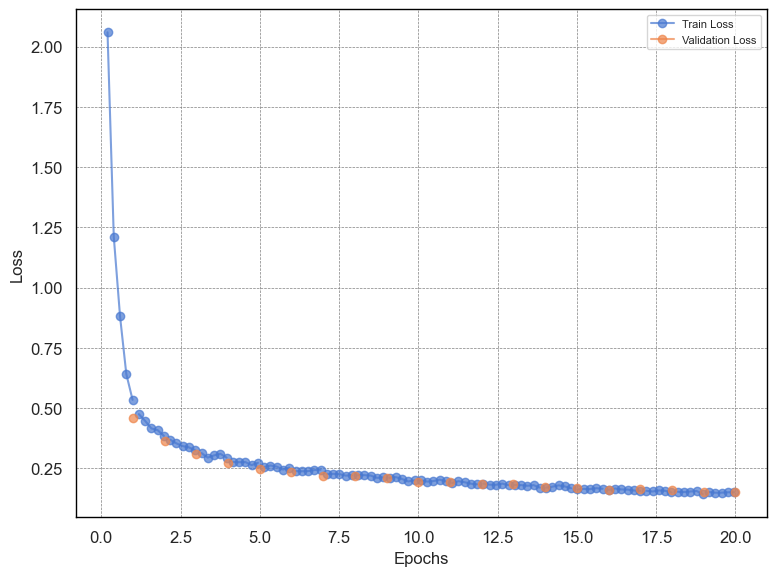

In [9]:
# Plotting Train Loss and Validation Loss against Epochs
plt.figure()

# Plot Train Loss
plt.plot(df['Epoch'], df['Train Loss'], label='Train Loss', marker='o', linestyle='-', alpha=0.7)

# Plot Validation Loss
plt.plot(df['Epoch'], df['Validation Loss'], label='Validation Loss', marker='o', linestyle='-', alpha=0.7)

# Adding labels, legend, and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig(f"{config['paths']['figures_dir']}/train_val_loss.png")
plt.show()
